# Gannett Peak Classifier Model and Predictions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
import pickle
from datetime import datetime

In [2]:
from sklearn.ensemble import RandomForestClassifier
from dataPrep import *

/opt/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
from IPython.display import HTML
import base64 

## Data for 2 months lagging

In [4]:
dOb = dataPrep()
X,y,Xtest,ytest = dOb.dataClass(2,False)

## Random Forest Model, based on tuned parameters

In [5]:
model = RandomForestClassifier(n_estimators=1000,
                                      min_samples_split=10,
                                      min_samples_leaf=2,
                                      max_features = None,
                                      max_depth = 10,
                                      bootstrap = True)

In [6]:
model.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Save model

In [7]:
filename = 'RF1.sav'
pickle.dump(model, open(filename, 'wb'))

## Evaluate Model

In [5]:
loadmodel = pickle.load(open("RF1.sav", 'rb'))

In [11]:
Xtest2 = Xtest.loc[:,Xtest.columns != 'Date']

In [13]:
y_pred=loadmodel.predict(Xtest2)
print(confusion_matrix(ytest, y_pred))
print(loadmodel.score(Xtest2, ytest))

[[ 958 4064]
 [1085 5068]]
0.5392393736017898


#### Model did not perform to the same standard as validation, about a 3% to 4% drop in accuracy for test set

## Feature Importance

Text(0.5,0,'Random Forest Feature Importance')

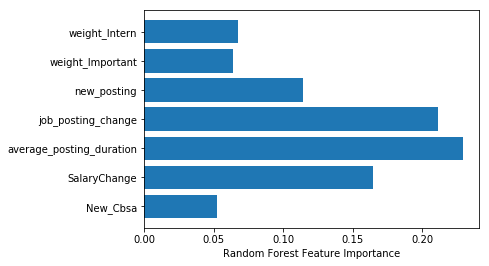

In [15]:
plt.barh(X.columns[:7], loadmodel.feature_importances_[:7])
plt.xlabel("Random Forest Feature Importance")

#### Looking at features common to all companies, excluding dummy variables, the job posting change, average posting duration, and change in average salary were of relatively high importance in determining the company performance.

## Create Output File of Predictions

In [14]:
tickCols = [col for col in Xtest if col.startswith('Ticker')]

In [15]:
columns = ['Ticker','2019-08','2019-09','2019-10','2019-11','2019-12','2020-01']

In [16]:
inDates = ['2019-06','2019-07','2019-08','2019-09','2019-10','2019-11']

In [27]:
def getTicker(row):
    '''
    For given row in Xtest, get the ticker as String
    '''
    tick = 'A'
    for col in tickCols:
        if row[col] == 1:
            tick = col[7:]
    return tick

def getDate(row):
    '''
    For given row in Xtest, get the date as String
    '''
    for i in range(len(inDates)):
        if row['Date'] == inDates[i]:
            return columns[i+1]

def appRow(outdf,ticker,date,ypi):
    '''
    Appends a row to output dataframe based on prediction, ticker, and date 
    '''
    if ypi == 1:
        if date == '2019-08':
            outdf = outdf.append(
                {
                    "Ticker":ticker,
                    '2019-08': 1,
                    '2019-09': 0,
                    '2019-10': 0,
                    '2019-11': 0,
                    '2019-12': 0,
                    '2020-01': 0
                }, ignore_index=True
            )
        elif date == '2019-09':
            outdf = outdf.append(
                {
                    "Ticker":ticker,
                    '2019-08': 0,
                    '2019-09': 1,
                    '2019-10': 0,
                    '2019-11': 0,
                    '2019-12': 0,
                    '2020-01': 0
                }, ignore_index=True
            )
        elif date == '2019-10':
            outdf = outdf.append(
                {
                    "Ticker":ticker,
                    '2019-08': 0,
                    '2019-09': 0,
                    '2019-10': 1,
                    '2019-11': 0,
                    '2019-12': 0,
                    '2020-01': 0
                }, ignore_index=True
            )
        elif date == '2019-11':
            outdf = outdf.append(
                {
                    "Ticker":ticker,
                    '2019-08': 0,
                    '2019-09': 0,
                    '2019-10': 0,
                    '2019-11': 1,
                    '2019-12': 0,
                    '2020-01': 0
                }, ignore_index=True
            )
        elif date == '2019-12':
            outdf = outdf.append(
                {
                    "Ticker":ticker,
                    '2019-08': 0,
                    '2019-09': 0,
                    '2019-10': 0,
                    '2019-11': 0,
                    '2019-12': 1,
                    '2020-01': 0
                }, ignore_index=True
            )
        elif date == '2020-01':
            outdf = outdf.append(
                {
                    "Ticker":ticker,
                    '2019-08': 0,
                    '2019-09': 0,
                    '2019-10': 0,
                    '2019-11': 0,
                    '2019-12': 0,
                    '2020-01': 1
                }, ignore_index=True
            )
    else:
        outdf = outdf.append(
                {
                    "Ticker":ticker,
                    '2019-08': 0,
                    '2019-09': 0,
                    '2019-10': 0,
                    '2019-11': 0,
                    '2019-12': 0,
                    '2020-01': 0
                }, ignore_index=True
            )
    
    return outdf

In [19]:
outdf = pd.DataFrame(columns = columns)

In [20]:
outdf

,Ticker,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01


In [21]:
for index, row in Xtest.iterrows():
    date = row.index.isin(['Date'])
    row2 = row.loc[~date]
    ypi = loadmodel.predict(row2.values.reshape(1,-1))[0]
    ticker = getTicker(row)
    date = getDate(row)
    outdf = appRow(outdf,ticker,date,ypi)

In [23]:
final = outdf.groupby(['Ticker']).max()

In [25]:
final.to_csv("RF_Prediction2.csv")

## Export CSV From JupyterLab

In [26]:
def create_download_link( df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv(index =True)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(final)

Link to source of above code, https://gist.github.com/HaiyangXu/244ae64d93c9142197791014f2a92503.